In [1]:
import json
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode
from scipy.signal import savgol_filter
import xgboost as xgb
from sklearn.metrics import mean_squared_error

addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'
if not os.path.exists(addressPrefix):
    addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Bobak/'
pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})

In [2]:
#Meal Format: Time, Carb, Fat, Protein to comply myfinesspal formating starting from Jan 31 til Feb 9
breakFast=[[31,'07-52-34',170,12,15],
[32,'07-09-13',170,12,60],
[33,'07-19-09',170,48,15],
[34,'06-47-38',170,12,15],
[35,'07-27-52',170,48,60],
[36,'07-18-46',42.5,12,15],
[37,'07-18-46',170,12,15],
[38,'07-44-07',170,12,60],
[39,'07-23-33',170,48,15],
[40,'06-50-00',170,12,15]]

lunch=[[31,'12-20-32',170,12,15],
[32,'12-19-09',170,12,60],
[33,'12-17-27',42.5,12,60],
[34,'12-11-35',170,12,60],
[35,'11-57-05',42.5,12,60],
[36,'12-35-21',170,48,60],
[37,'12-08-40',42.5,12,60],
[38,'11-22-23',170,12,15],
[39,'12-16-25',42.5,12,60],
[40,'12-12-34',170,48,15]]

dinner=[[31,'17-55-02',84,50,27],
[32,'17-21-14',49,28,41],
[33,'17-50-56',21,28,53],
[34,'17-45-17',70,35,39],
[35,'17-18-12',110,28,46],
[36,'17-41-39',53,51,67],
[37,'16-44-56',68,39,25],
[38,'15-58-07',71,52,82],
[39,'16-59-39',66,43,28],
[40,'17-44-56',122,47,51]]

mealData=[]
mealTemp=breakFast
mealTemp.extend(lunch)
mealTemp.extend(dinner)

for element in mealTemp:
    timeTemp = datetime.strptime(element[1], '%H-%M-%S')
    timeTemp=timeTemp.time()
    timeTemp=timeTemp.hour*3600+timeTemp.minute*60+timeTemp.second
    mealData.append([element[0],timeTemp,element[2],element[3],element[4]])

dfMacro=pd.DataFrame(data=mealData,columns=['Date','Time','Carb','Fat','Protein'])

In [18]:
def loadingDataReader(fileAddress,parameter):
    try:
        jsonFile = open(fileAddress, )
        data = json.load(jsonFile)

        dateList=[]
        timeList=[]
        valList=[]
        for i in data:
            for j in data[i]:
                timeTemp=j["time"]
                timeTemp=int(timeTemp[0:2])*3600+int(timeTemp[3:5])*60+int(timeTemp[6:8])
                timeList.append(timeTemp)

                dateTemp=i
                dateTemp = datetime.strptime(dateTemp, '%m-%d')+relativedelta(years=+121)
                dateTemp=dateTemp.timetuple().tm_yday
                dateList.append(dateTemp)
                valList.append(float(j["value"]))
        jsonFile.close()
    except:
        print("An exception occurred")

    parList = []
    for i in range (0,len(dateList)):
        parList.append(parameter)

    return dateList,timeList,valList,parList

def loadingDataAux(fileAddress,parameter,allDate,allTime,allVal,allPar):
    fileAddress=os.path.normpath(fileAddress)
    [tempDate,tempTime,tempVal,tempPar]=loadingDataReader(fileAddress,parameter)
    allDate.extend(tempDate)
    allTime.extend(tempTime)
    allVal.extend(tempVal)
    allPar.extend(tempPar)
    print(parameter," is done")

    return allDate,allTime,allVal,allPar

def dataResEnhancer(df):
    gapLength=1
    df=df.sort_values(by=['Parameter', 'Date','Time'])
    gapList=[]

    highResSensor=['Acc','EDA','HR','Temp','CGM']
    for sensor in highResSensor:
        newQuery=df[df['Parameter']==sensor]
        for counter in range(0,len(newQuery)-1):
            if newQuery.iloc[counter+1,0]==newQuery.iloc[counter+1,0]:
                if newQuery.iloc[counter+1,1]-newQuery.iloc[counter,1]>gapLength:
                    gapList.append([newQuery.iloc[counter,0],newQuery.iloc[counter,1],newQuery.iloc[counter+1,1],newQuery.iloc[counter,3]])
    appendedData=[]
    for element in gapList:
        duration= element[2]-element[1]
        if duration%gapLength==0:
            fillerNumber=int(duration/gapLength-1)
        else:
            fillerNumber=int(duration/gapLength)
        for counter in range(0,fillerNumber):
            appendedData.append([element[0],element[1]+(counter+1)*gapLength,float('nan'),element[3]])

    df = df.append(pd.DataFrame(appendedData,columns=['Date','Time','Value','Parameter']),ignore_index = True)
    df=df.sort_values(by=['Parameter','Date','Time'])

    df=df.interpolate(method='linear')
    return df

def dataCleaner(df):
    i = df[df.Date == 30].index #first data and noisy
    df=df.drop(i)

    i = df[df.Date == 40].index #Partial E4
    df=df.drop(i)

    i = df[df.Date == 41].index #No E4
    df=df.drop(i)

    i = df[df.Date >= 42].index #CGM becomes too noisy at the end of the study
    df=df.drop(i)

    return df

def dataAmputator(df):
    amputations=[[31,38290,39010],[31,61937,62638],[31,66226,71099],
              [32,58667,59563],[32,63875,63902],
              [33,25127,34731],[33,57996,58812],
              [34,25556,30763],[34,58736,59877],[34,66069,66092],
              [35,27945,31416],[35,57283,58147],
              [36,29865,33926],[36,59231,60096],
              [37,26911,32544],[37,40214,41380],
              [38,26707,34560],[38,38172,39273],
              [39,31053,35335],[39,57408,58655]]

    for amputation in amputations:
        i=df[(df['Date']==amputation[0]) & (df['Time']>=amputation[1]) & (df['Time']<=amputation[2])].index
        df.loc[i,'Value']=float('nan')
        # df=df.drop(i)
    df=df.interpolate(method='linear')
    return df

def loadingData(addressPrefix):
    if not os.path.exists(addressPrefix+'Result-interpolated.csv'):
        allDate=[]
        allTime=[]
        allVal=[]
        allPar=[]

        sensorList=[['intraday-ACC_E4.json','Acc'],['intraday-calories.json','Cal'],
                    ['intraday-EDA_E4.json','EDA'],['intraday-HR_E4.json','HR'],
                    ['intraday-steps.json','Step'],['intraday-TEMP_E4.json','Temp'],
                    ['intraday-glucose.json','CGM']]

        for element in sensorList:
            fileAddress=addressPrefix+element[0]
            allDate,allTime,allVal,allPar=loadingDataAux(fileAddress,element[1],allDate,allTime,allVal,allPar)

        dfOriginal = pd.DataFrame(list(zip(allDate,allTime,allVal,allPar)),
                          columns =['Date','Time','Value','Parameter'])
        dfOriginal=dfOriginal.sort_values(by=['Parameter','Date','Time'])
        dfOriginal.to_csv(addressPrefix+'Result-original.csv', header=True,index=False)
        print("Result-Original is saved")
        dfInterp=dataCleaner(dfOriginal)
        dfInterp=dataResEnhancer(dfInterp)
        dfInterp=dataAmputator(dfInterp)
        dfInterp.to_csv(addressPrefix+'Result-interpolated.csv', header=True,index=False)
        print("Result-Interpolated is saved")
    else:
        dfOriginal=pd.read_csv(addressPrefix+'Result-original.csv')
        dfInterp=pd.read_csv(addressPrefix+'Result-interpolated.csv')
    return dfOriginal,dfInterp

dfOriginal,dfInterp=loadingData(addressPrefix)

c:\users\sorush.omidvar\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


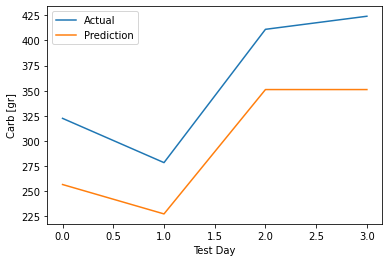

In [86]:
def STMI_XGBoost(trainData,testData,trainLabels,testLabels):
    clf = xgb.XGBRegressor(n_estimators =10,max_depth=10,objective ='reg:squarederror',eval_metric = "logloss",use_label_encoder =False)
    clf.fit(trainData, trainLabels)
    testPrediction = clf.predict(testData)
    mse = mean_squared_error(testLabels, testPrediction)
    return mse,testPrediction

    # accuracyBest=-1
    # confMatrixBest=[]
    # for threshold in np.arange(0.4,0.8,0.2):
    #     for eta in np.arange(0.05,0.50,0.05):
    #         for maxDepth in np.arange(3,10):
    #             clf = XGBClassifier(eta=eta,max_depth=maxDepth,objective = "binary:logistic",eval_metric = "logloss",use_label_encoder =False)
    #             clf.fit(trainData, trainLabels)
    #             slidingWindowPrediction = clf.predict_proba(testData)
    #             slidingWindowPrediction=slidingWindowPrediction[:,1]
    #             slidingWindowPrediction[slidingWindowPrediction>=threshold]=1
    #             slidingWindowPrediction[slidingWindowPrediction<threshold]=0
    #
    #             confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction)
    #             accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)
    #
    #             if accuracy>accuracyBest:
    #                 confMatrixBest=confMatrix
    #                 accuracyBest=accuracy
    #                 threshBest=threshold
    #                 modelBest=clf
    #
    # features=np.round(modelBest.feature_importances_*100,1)
    # # saveModel('XG',modelBest,threshBest,patientName,testDay)
    #
    # return modelBest,confMatrixBest,threshBest,features
def aucCalculator(timeTemp,dataTemp,kernelNumber):
    kernelMeans=np.linspace(0,24,kernelNumber+2)
    kernelMeans=np.delete(kernelMeans,0)
    kernelMeans=np.delete(kernelMeans,-1)
    kernelMeans=kernelMeans*3600

    kernelSTD=2*3600
    aucData=[]
    for kernelMean in kernelMeans:
        kernelTemp=np.exp(-((timeTemp-kernelMean)**2)/(2*kernelSTD**2))
        tempAuc=kernelTemp*dataTemp
        tempAuc=np.trapz(tempAuc,x=timeTemp)
        aucData.append(tempAuc)

    return aucData

def statisticalFeature(timeTemp,dataTemp):
    featureList=[]

    featureList.append(np.mean(dataTemp))
    featureList.append(np.median(dataTemp))
    featureList.append(np.max(dataTemp))
    featureList.append(np.min(dataTemp))
    featureList.append(np.var(dataTemp))

    featureList.append(np.mean(np.diff(dataTemp,n=1)))
    # featureList.append(np.median(np.diff(dataTemp,n=1)))
    featureList.append(np.max(np.diff(dataTemp,n=1)))
    featureList.append(np.min(np.diff(dataTemp,n=1)))
    # featureList.append(np.var(np.diff(dataTemp,n=1)))

    featureList.append(np.mean(np.diff(dataTemp,n=2)))
    # featureList.append(np.median(np.diff(dataTemp,n=2)))
    # featureList.append(np.max(np.diff(dataTemp,n=2)))
    # featureList.append(np.min(np.diff(dataTemp,n=2)))
    # featureList.append(np.var(np.diff(dataTemp,n=2)))

    featureList.append(np.trapz(dataTemp))

    return featureList

def featureExtractor(df):
    featureList=[]
    sensors=['EDA', 'Acc', 'CGM', 'Temp', 'HR']

    #CAL and STEP IS REMOVED!!!!!!!!

    for sensor in sensors:
        varData=df[df['Parameter']==sensor]
        varTime=varData['Time'].tolist()
        varData=varData['Value'].tolist()

        varTime=np.asarray(varTime)
        varData=np.asarray(varData)
        # featureList.extend(statisticalFeature(varTime,varData))
        if sensor=='CGM':
            featureList.extend(aucCalculator(varTime,varData,9))
            featureList.extend(aucCalculator(varTime,varData,6))
            featureList.extend(aucCalculator(varTime,varData,3))

    #REDO IT WITH FITBIT AND E4
    #FOR MEAL TO MEAL PERSPECTIVE, MAKE THE WHOLE DAY INTO 3 CHUNCKS (MEAL TO MEAL)
    #PLOT DAY-DAY VS MEAL TO MEAL AND SHOW THEM HOW WE ARE SEAPRATING THINGS (CGM,EDA,...)

    #https://github.com/fraunhoferportugal/tsfel/tree/9319db4368303cf10adb3aeb72cd4235a8085307
    return featureList


def testTrainSplitFuncAux(dfSensorTemp,dfMacroTemp):
    sensorDataList=[]
    macroDataList=[]
    days=list(set(dfSensorTemp['Date']))

    for day in days:
        dfSensorTempDay=dfSensorTemp[dfSensorTemp['Date']==day]
        sensorDataList.append(featureExtractor(dfSensorTempDay))
        dfMacroTempDay=dfMacroTemp[dfMacroTemp['Date']==day]
        totalCarb=dfMacroTempDay['Carb'].sum()
        totalFat=dfMacroTempDay['Fat'].sum()
        totalProtein=dfMacroTempDay['Protein'].sum()
        macroDataList.append([totalCarb,totalFat,totalProtein])

    return sensorDataList,macroDataList

def testTrainSplitFunc(dfSensor, dfMacro):
    days=list(set(dfSensor['Date']))
    random.shuffle(days)
    daysTrain=days[0:5]
    daysTest=days[5:9]

    dfSensorTrain = dfSensor[dfSensor['Date'].isin(daysTrain)]
    dfSensorTest = dfSensor[dfSensor['Date'].isin(daysTest)]

    dfMacroTrain= dfMacro[dfMacro['Date'].isin(daysTrain)]
    dfMacroTest= dfMacro[dfMacro['Date'].isin(daysTest)]

    trainData,trainLabel=testTrainSplitFuncAux(dfSensorTrain,dfMacroTrain)
    testData,testLabel=testTrainSplitFuncAux(dfSensorTest,dfMacroTest)

    trainData=np.asarray(trainData)
    testData=np.asarray(testData)

    trainLabel=np.asarray(trainLabel)
    testLabel=np.asarray(testLabel)

    trainLabel=trainLabel[:,0]
    testLabel=testLabel[:,0]

    return trainData,testData,trainLabel,testLabel

trainData,testData,trainLabel,testLabel=testTrainSplitFunc(dfInterp,dfMacro)
mse,predictions=STMI_XGBoost(trainData,testData,trainLabel,testLabel)

plt.plot(testLabel,label='Actual')
plt.plot(predictions,label='Prediction')

plt.xlabel('Test Day')
plt.ylabel('Carb [gr]')
plt.legend()

In [ ]:

windowDuration=2
lagTimes=np.arange(-2,2.5,0.5)
mealTimes=[12.33,12.33,12.33,12.16,11.92,12.5,12.16,11.33,12.25]
plotFlag=False
plotParamter='Temp'

pearsonRatios=[]
days=dfInterp['Date']
days=days.values.tolist()
days=set(days)
days=list(days)
days.sort()
pearsonRatios=np.zeros((len(lagTimes),len(days)))
for i,lagTime in enumerate(lagTimes):
    for counter,day in enumerate(days):
        mealTime=mealTimes[counter]
        queryCGM=dfInterp[dfInterp['Date']==day]
        queryCGM['Time']=queryCGM['Time']/3600
        queryCGM=queryCGM[queryCGM['Parameter']=='CGM']
        queryCGM=queryCGM[queryCGM['Time']<=(mealTime+windowDuration)]
        queryCGM=queryCGM[queryCGM['Time']>=mealTime]

        queryVar=dfInterp[dfInterp['Date']==day]
        queryVar['Time']=queryVar['Time']/3600
        queryVar=queryVar[queryVar['Parameter']==plotParamter]
        queryVar=queryVar[queryVar['Time']<=(mealTime+windowDuration+lagTime)]
        queryVar=queryVar[queryVar['Time']>=(mealTime+lagTime)]
        if plotFlag:
            fig, ax1 = plt.subplots ()
            ax2 = ax1.twinx ()

            queryCGM.plot(ax=ax1,x='Time',y='Value',color='green')
            ax1.tick_params (axis='y', labelcolor='green')

            queryVar.plot(ax=ax2,x='Time',y='Value',color='red')
            ax2.tick_params (axis='y', labelcolor='red')

            ax1.set_ylabel('CGM')
            ax1.set_xlabel('Day')
            ax1.yaxis.label.set_color("green")

            ax2.set_ylabel(plotParamter)
            ax2.yaxis.label.set_color("red")

            # plt.savefig(addressPrefix+'figure'+str(day)+'.jpg')
            plt.title("Day="+str(day))
            ax1.get_legend().remove()
            ax2.get_legend().remove()
            plt.show()
        CGMData=queryCGM['Value'].values.tolist()
        CGMData=np.asarray(CGMData)
        varData=queryVar['Value'].values.tolist()
        varData=np.asarray(varData)
        discardIndex=np.argwhere(np.isnan(varData))
        varData=np.delete(varData,discardIndex)
        CGMData=np.delete(CGMData,discardIndex)
        corr, pval = pearsonr(CGMData,varData)
        # pearsonRatios.append([lagTime,day,np.round(corr,3)])
        pearsonRatios[i,counter]=np.round(corr,3)

for i,lagTime in enumerate(lagTimes):
    print("Lag time=",lagTime,"Mean pearson=",np.round(np.mean(pearsonRatios[i,:]),3))
    print(pearsonRatios[i,:])
    print("----------------------")
plt.boxplot(pearsonRatios)
plt.xticks(np.arange(1,len(lagTimes)+1), lagTimes)
plt.ylabel('Pearson Corr')
plt.xlabel('Lag between CGM and Var [hr]')
plt.show()